In [2]:
# for pgmpy to work you will need to downgrade your version of numpy
# pip install "numpy<2.0" pgmpy
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib import pyplot as plt
import networkx as nx
# install R and dagitty first: install.packages("dagitty")
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Import R's dagitty
dagitty = importr('dagitty')

In [3]:
# functions
def sim_weight(lengths, sd, beta_w):
    random_variation = np.random.normal(0, sd, len(lengths))  # random noise
    weights = beta_w*lengths + random_variation
    return weights

def sim_colour(lengths, sd, beta_c):
    random_variation = np.random.normal(0, sd, len(lengths))  # random noise
    colour = beta_c*lengths + random_variation
    return colour

def sim_predation(colours, weights, sd, beta_c, beta_w):
    random_variation = np.random.normal(0, sd, len(colours))  # random noise
    predation = beta_c*colours + beta_w*weights + random_variation
    return predation

def sim_reproduction(colours, weights, sd, beta_c, beta_w):
    random_variation = np.random.normal(0, sd, len(colours))  # random noise
    reproduction = beta_c*colours + beta_w*weights + random_variation
    return reproduction

# Lab 3 - All about the DAGS

**Author:** Arun Oakley-Cogan  
**Date:** 2025-10-06

Our objective today is to revisit DAGS, and how we use statistical models to test if our DAGs are consistent with our data.

"DAGs are used to represent causal relationships within a given system. A DAG consists of a set of nodes (variables) that are connected to each other by edges (arrows). These arrows represent causal relationships between variables, pointing from cause to effect, with causes preceding their effects." (Arif & MacNeil, 2023)

Once we have created a DAG, we can test it against our observed data to check for DAG-data consistency.

What does this mean? A DAG often asserts multiple independencies (variables are considered to be independent of each other) that should be true in our data, if both the DAG and our data are representative of the system.

In a DAG, a pair of variables can be independent of each other (e.g., Weight is independent of Colour) if there are no paths (i.e., a sequence of nodes and arrows) connecting them. Also, a pair of variables can be conditionally independent.

Conditional independencies emerge from separating the dependency (blocking the path).

For our DAG to be considered consistent with our data, all the independencies & conditional independencies need to hold true in our observed data. We can test for these.

## Fork

When a node in our DAG is a common cause of two variables

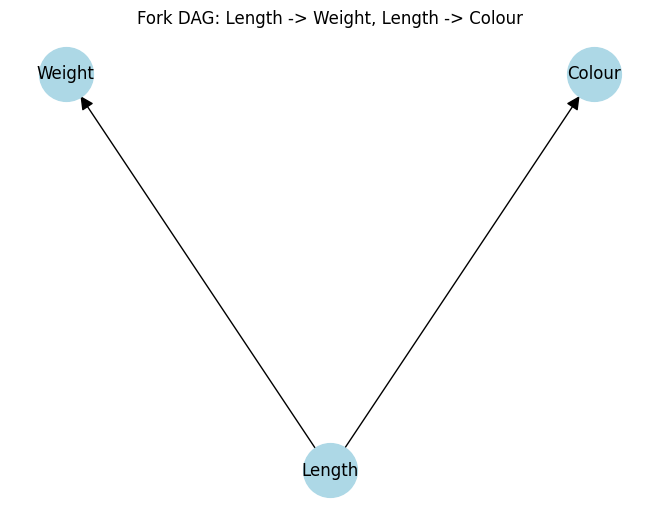

In [4]:
# draw dag
dag = dagitty.dagitty("dag{ Length -> Weight Length -> Colour }")

# extract edges for Python plotting
edges_r = ro.r('function(d) { e <- edges(d); data.frame(from=e$v, to=e$w) }')(dag)
edges = [(str(edges_r[0][i]), str(edges_r[1][i])) for i in range(len(edges_r[0]))]

dag_nx = nx.DiGraph(edges)
pos = {
    'Length': (0, 0),      # x, y coordinates
    'Weight': (-1, 1),
    'Colour': (1, 1)
}
nx.draw(dag_nx, pos, with_labels=True, node_color='lightblue',
        node_size=1500, arrowsize=20, arrows=True)
plt.title("Fork DAG: Length -> Weight, Length -> Colour")
plt.show()

In [5]:
# implied indepencies of DAG
print("\nImplied conditional independencies:")
print(dagitty.impliedConditionalIndependencies(dag))


Implied conditional independencies:
Colr _||_ Wght | Lngt



What does this mean? We can read this statement as, conditional on us including `Length` in the model , `Weight` should be independent of `Colour` - that is, we should not see an effect if we regress them together. Let's do that and see.

In [6]:
# number of frogs
n_frog = 75
# generate some lengths
lengths = np.random.normal(0, 1, n_frog)
# Length -> Weight
weights = sim_weight(lengths, 1, 1)
# Length -> Colour
colours = sim_colour(lengths, 1, -1)

# package data
frog_data = {
    'weights': weights,
    'lengths': lengths,
    'colours': colours
}

In [7]:
# test for independence
# specify models
with pm.Model() as fork_model_full:
    # priors
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_c = pm.Normal("beta_c", 0, 1)
    beta_l = pm.Normal("beta_l", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_c*frog_data['colours'] + beta_l*frog_data['lengths'])
    
    # data likelihood
    weights_obs = pm.Normal("weights", mu, sigma, observed=frog_data['weights'])
    
with pm.Model() as fork_model_no_length:
    # priors
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_c = pm.Normal("beta_c", 0, 1)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_c*frog_data['colours'])

    # data likelihood
    weights_obs = pm.Normal("weights", mu, sigma, observed=frog_data['weights'])

# fit and sample models
fork_full_idata = pm.sample(chains=4, model=fork_model_full)
fork_no_length_idata = pm.sample(chains=4, model=fork_model_no_length)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_c, beta_l, sigma]


/Users/aoakley/Library/Mobile 
Documents/com~apple~CloudDocs/Active_Projects/Dalhousie/AppliedBayes_2025/.venv/lib/python3.12/site-packages/rich/l
ive.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_c, sigma]


/Users/aoakley/Library/Mobile 
Documents/com~apple~CloudDocs/Active_Projects/Dalhousie/AppliedBayes_2025/.venv/lib/python3.12/site-packages/rich/l
ive.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


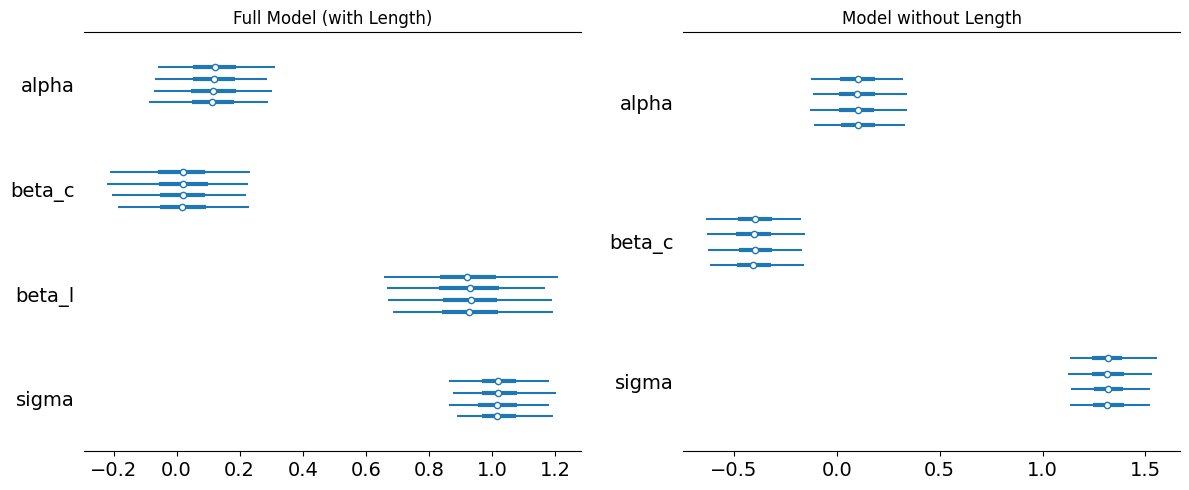

In [8]:
# Compare models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

az.plot_forest(fork_full_idata, var_names=['alpha', 'beta_c', 'beta_l', 'sigma'], ax=axes[0])
axes[0].set_title('Full Model (with Length)')

az.plot_forest(fork_no_length_idata, var_names=['alpha', 'beta_c', 'sigma'], ax=axes[1])
axes[1].set_title('Model without Length')

plt.tight_layout()
plt.show()

Here you can see when we include length in the model, there is a zero effect size, indicating that colour has no effect on weight, and our independency holds. Our DAG is consistent with our data!

In causal inference we are trying to understand causal effects of one variable on another. Effects (for now) can either be **direct** or **total** and they flow from an **exposure** to an **outcome**.

Exposure and outcome are determined by your research question. Exposure is the variable with the causal effect you want to estimate. This is the cause you're interested in. The outcome is a variable you want to explain / predict. This is the effect you are measuring.

A **direct** effect is the causal influence that flows from an **exposure** to an **outcome** directly along the arrows that connect them, they help us understand mechanisms. A **total** effect is the overall influence of exposure to the outcome through **all** causal pathways, total effects help us understand the overall impact.

In [9]:
# adjustment sets
print(dagitty.adjustmentSets(dag, exposure='Weight', outcome='Colour'))

{ Length }



Conditioning on / adjusting for / including in your model will close backdoor paths if they exist for all elemental confounds EXCEPT for colliders, where including them will OPEN a backdoor path

We can see here that by adjusting for length, we have closed the backdoor path between Weight and Colour, and can estimate the underlying effect of weight on colour.

In [15]:
# paths
print(dagitty.paths(dag, 'Weight', 'Colour'))
print(dagitty.paths(dag, 'Weight', 'Colour', Z=ro.StrVector(['Length'])))

$paths
[1] "Weight <- Length -> Colour"

$open
[1] TRUE


$paths
[1] "Weight <- Length -> Colour"

$open
[1] FALSE




## Pipe

Here, our causal assumptions are that:

**Length** causes **Colour** which causes **Reproduction**

**Length** causes **Weight** which also causes **Reproduction**

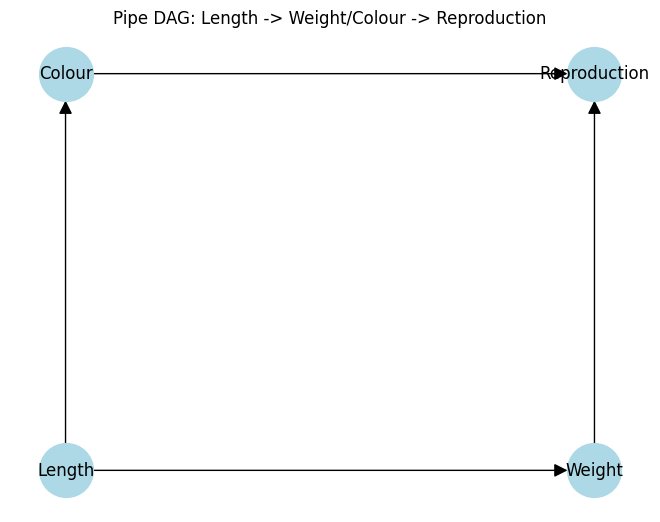

In [20]:
# draw dag
dag = dagitty.dagitty("dag{ Length -> Weight Length -> Colour Colour-> Reproduction Weight-> Reproduction}")

# extract edges for Python plotting
edges_r = ro.r('function(d) { e <- edges(d); data.frame(from=e$v, to=e$w) }')(dag)
edges = [(str(edges_r[0][i]), str(edges_r[1][i])) for i in range(len(edges_r[0]))]

dag_nx = nx.DiGraph(edges)
# set coordinates
pos = {
    'Length': (0, 0),
    'Weight': (1, 0),
    'Colour': (0, 1),
    'Reproduction': (1, 1)
}
# draw dag
nx.draw(dag_nx, pos, with_labels=True, node_color='lightblue',
        node_size=1500, arrowsize=20, arrows=True)
plt.title("Pipe DAG: Length -> Weight/Colour -> Reproduction")
plt.show()


In [21]:
# implied indepencies of DAG
print("\nImplied conditional independencies:")
print(dagitty.impliedConditionalIndependencies(dag))


Implied conditional independencies:
Colr _||_ Wght | Lngt
Lngt _||_ Rprd | Colr, Wght



In [ ]:
# colour -> reproduction, weight->reproduction
reproduction = sim_reproduction(colours, weights, sd=1, beta_c=-1.5, beta_w=1)

# add reproduction to data set
frog_data['reproduction'] = reproduction

In [ ]:
# testing for independence
with pm.Model() as pipe_model_full:
    # priors
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_c = pm.Normal("beta_c", 0, 1)
    beta_l = pm.Normal("beta_l", 0, 0.8)
    beta_w = pm.Normal("beta_w", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_c*frog_data['colours'] + beta_l*frog_data['lengths'] + beta_w*frog_data['weights'])
    
    # data likelihood
    reproduction_obs = pm.Normal("reproduction", mu, sigma, observed=frog_data['reproduction'])

with pm.Model() as pipe_model_no_cw:
    # priors
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_l = pm.Normal("beta_l", 0, 0.8)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_l*frog_data['lengths'])

    # data likelihood
    reproduction_obs = pm.Normal("reproduction", mu, sigma, observed=frog_data['reproduction'])

pipe_full_idata = pm.sample(chains=4, model=pipe_model_full)
pipe_no_cw_idata = pm.sample(chains=4, model=pipe_model_no_cw)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

az.plot_forest(pipe_full_idata, var_names=['alpha', 'beta_c', 'beta_l', 'beta_w', 'sigma'], ax=axes[0])
axes[0].set_title('Full Model (with Colour and Weight)')

az.plot_forest(pipe_no_cw_idata, var_names=['alpha', 'beta_l', 'sigma'], ax=axes[1])
axes[1].set_title('Model without Colour and Weight')

plt.tight_layout()
plt.show()

In [25]:
# adjustment sets
print(dagitty.adjustmentSets(dag, exposure='Length', outcome='Reproduction', effect="total"))
print(dagitty.adjustmentSets(dag, exposure='Length', outcome='Reproduction', effect="direct"))

# paths
print(dagitty.paths(dag, 'Weight', 'Colour'))
print(dagitty.paths(dag, 'Weight', 'Colour', Z=ro.StrVector(['Colour', 'Weight'])))

 {}

{ Colour, Weight }

$paths
[1] "Weight -> Reproduction <- Colour" "Weight <- Length -> Colour"      

$open
[1] FALSE  TRUE


$paths
[1] "Weight -> Reproduction <- Colour" "Weight <- Length -> Colour"      

$open
[1] FALSE FALSE




## Collider

When a variable has two separate causes. Adjusting for colliders opens back door paths

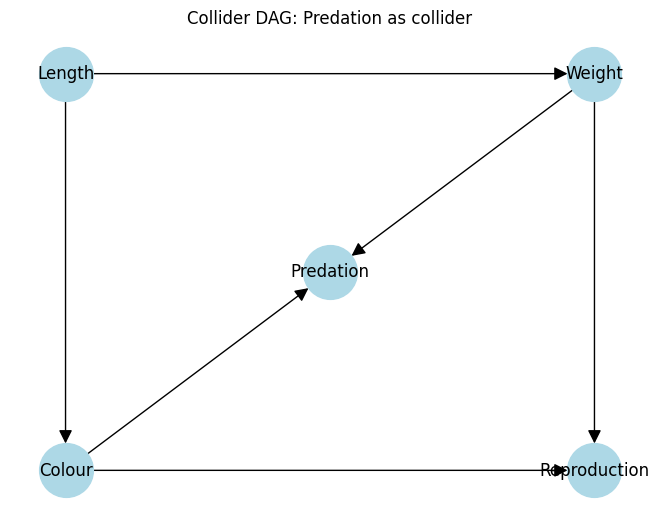

In [26]:
# draw dag
dag = dagitty.dagitty("dag{ Length -> Weight Length -> Colour Colour-> Reproduction Colour->Predation Weight->Predation Weight->Reproduction}")

# extract edges for Python plotting
edges_r = ro.r('function(d) { e <- edges(d); data.frame(from=e$v, to=e$w) }')(dag)
edges = [(str(edges_r[0][i]), str(edges_r[1][i])) for i in range(len(edges_r[0]))]

dag_nx = nx.DiGraph(edges)
# set coordinates
pos = {
    'Colour': (0, 0),
    'Length': (0, 1),
    'Reproduction': (1, 0),
    'Weight': (1, 1),
    'Predation': (0.5, 0.5)
}
# draw dag
nx.draw(dag_nx, pos, with_labels=True, node_color='lightblue',
        node_size=1500, arrowsize=20, arrows=True)
plt.title("Collider DAG: Predation as collider")
plt.show()

In [27]:
# implied indepencies of DAG
print("\nImplied conditional independencies:")
print(dagitty.impliedConditionalIndependencies(dag))


Implied conditional independencies:
Colr _||_ Wght | Lngt
Lngt _||_ Prdt | Colr, Wght
Lngt _||_ Rprd | Colr, Wght
Prdt _||_ Rprd | Colr, Wght



### Simulate our data.

In [39]:
# colour -> predation, weight -> predation
predation = sim_predation(colours, weights, sd=1, beta_c=1.5, beta_w=1)

# add predation to data set
frog_data['predation'] = predation

In [ ]:
# Length _||_ Predation | Colour, Weight
with pm.Model() as predation_model:
    # priors
    alpha = pm.Normal("alpha", 0, 0.2)
    beta_c = pm.Normal("beta_c", 0, 1)
    beta_l = pm.Normal("beta_l", 0, 0.2)
    beta_w = pm.Normal("beta_w", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    # linear model
    mu = pm.Deterministic("mu", alpha + beta_c*frog_data['colours'] + beta_l*frog_data['lengths'] + beta_w*frog_data['weights'])
    
    # data likelihood
    predation_obs = pm.Normal("predation", mu, sigma, observed=frog_data['predation'])

# Length _||_ Reproduction | Colour, Weight
with pm.Model() as predation_model2:
    # priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_c = pm.Normal("beta_c", 0, 1)
    beta_r = pm.Normal("beta_r", 0, 1)
    beta_w = pm.Normal("beta_w", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = pm.Deterministic("mu", alpha + beta_c*frog_data['colours'] + beta_r*frog_data['reproduction'] + beta_w*frog_data['weights'])

    # data likelihood
    predation_obs = pm.Normal("predation", mu, sigma, observed=frog_data['predation'])

predation_idata = pm.sample(chains=4, model=predation_model)
predation2_idata = pm.sample(chains=4, model=predation_model2)

In [ ]:
# Compare models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

az.plot_forest(predation_idata, var_names=['alpha', 'beta_c', 'beta_l', 'beta_w', 'sigma'], ax=axes[0])
axes[0].set_title('Predation Model (with Length)')

az.plot_forest(predation2_idata, var_names=['alpha', 'beta_c', 'beta_r', 'beta_w', 'sigma'], ax=axes[1])
axes[1].set_title('Predation Model (with Reproduction)')

plt.tight_layout()
plt.show()

Again, our conditional independencies hold true and we have DAG-DATA Consistency.

What about our causal inference?

In [28]:
# adjustment sets
print(dagitty.adjustmentSets(dag, exposure='Length', outcome='Reproduction', effect="total"))
print(dagitty.adjustmentSets(dag, exposure='Length', outcome='Reproduction', effect="direct"))

# paths
print(dagitty.paths(dag, 'Length', 'Reproduction'))
print(dagitty.paths(dag, 'Length', 'Reproduction', Z=ro.StrVector(['Predation'])))

 {}

{ Colour, Weight }

$paths
[1] "Length -> Colour -> Predation <- Weight -> Reproduction"
[2] "Length -> Colour -> Reproduction"                       
[3] "Length -> Weight -> Predation <- Colour -> Reproduction"
[4] "Length -> Weight -> Reproduction"                       

$open
[1] FALSE  TRUE FALSE  TRUE


$paths
[1] "Length -> Colour -> Predation <- Weight -> Reproduction"
[2] "Length -> Colour -> Reproduction"                       
[3] "Length -> Weight -> Predation <- Colour -> Reproduction"
[4] "Length -> Weight -> Reproduction"                       

$open
[1] TRUE TRUE TRUE TRUE




**References**

1. Arif S, MacNeil MA. Applying the structural causal model framework for observational causal inference in ecology. Ecological Monographs. 2023;93(1):e1554. 
2. Mcelreath R. Statistical Rethinking 2 A Bayesian Course with Examples in R and Stan Second Edition. 2nd ed. 2020.